# Functions

In [1]:
import sys


sys.path.append("../")

## MP4 functions

In [2]:
import cv2
from IPython.display import clear_output, display, HTML
from base64 import b64encode


def play_video(video_path):
    video = cv2.VideoCapture(video_path)
    while True:
        ret, frame = video.read()
        if not ret:
            break
        clear_output(wait=True)
        _, buffer = cv2.imencode('.jpg', frame)
        display(HTML('<img src="data:image/jpeg;base64,{}">'.format(b64encode(buffer).decode())))
        # time.sleep(0.1)
    video.release()

## Data transform functions

In [3]:
import torchvision.transforms.functional as F


def process_image(image):
    ori_image = image.copy()
    h, w = image.shape[:2]
    scale = 800 / min(h, w)
    if max(h, w) * scale > 1536:
        scale = 1536 / max(h, w)
    target_h = int(h * scale)
    target_w = int(w * scale)
    image = cv2.resize(image, (target_w, target_h))
    image = F.normalize(F.to_tensor(image), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    return image, ori_image

## Tracking functions and classes

In [4]:
import torch
from structures.track_instances import TrackInstances


def filter_by_score(tracks: TrackInstances, thresh: float = 0.7):
    keep = torch.max(tracks.scores, dim=-1).values > thresh
    return tracks[keep]

def filter_by_area(tracks: TrackInstances, thresh: int = 100):
    assert len(tracks.area) == len(tracks.ids), f"Tracks' 'area' should have the same dim with 'ids'"
    keep = tracks.area > thresh
    return tracks[keep]

## Plot functions

In [5]:
import numpy as np
import cv2


def get_color(idx):
    idx = idx * 3
    color = ((37 * idx) % 255, (17 * idx) % 255, (29 * idx) % 255)

    return color

def plot_tracking(image, tlwhs, obj_ids, scores=None, frame_id=0, fps=0., ids2=None):
    # Thanks to https://github.com/noahcao/OC_SORT
    im = np.ascontiguousarray(np.copy(image))
    im_h, im_w = im.shape[:2]

    top_view = np.zeros([im_w, im_w, 3], dtype=np.uint8) + 255
    text_scale = 2
    text_thickness = 2
    line_thickness = 3

    radius = max(5, int(im_w/140.))
    cv2.putText(im, 'frame: %d fps: %.2f num: %d' % (frame_id, fps, len(tlwhs)),
                (0, int(15 * text_scale)), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), thickness=2)

    for i, tlwh in enumerate(tlwhs):
        x1, y1, w, h = tlwh
        intbox = tuple(map(int, (x1, y1, x1 + w, y1 + h)))
        obj_id = int(obj_ids[i])
        id_text = '{}'.format(int(obj_id))
        if ids2 is not None:
            id_text = id_text + ', {}'.format(int(ids2[i]))
        color = get_color(abs(obj_id))
        cv2.rectangle(im, intbox[0:2], intbox[2:4], color=color, thickness=line_thickness)
        cv2.putText(im, id_text, (intbox[0], intbox[1]), cv2.FONT_HERSHEY_PLAIN, text_scale, (0, 0, 255),
                    thickness=text_thickness)
    return im

## Demo (inference) functions

In [6]:
import cv2
import time
import os.path
import sys
import numpy as np
from models import build_model
from models.utils import load_checkpoint
from utils.utils import yaml_to_dict

import torch
from typing import List
from models import build_model
from models.utils import load_checkpoint, get_model
from models.runtime_tracker import RuntimeTracker
from utils.utils import yaml_to_dict, is_distributed, distributed_world_size, distributed_rank, inverse_sigmoid
from utils.nested_tensor import tensor_list_to_nested_tensor
from utils.box_ops import box_cxcywh_to_xyxy
from structures.track_instances import TrackInstances


def demo_processing(
        model_path: str,
        config_path: str,
        video_path: str,
):
    config = yaml_to_dict(config_path)
    model = build_model(config)
    load_checkpoint(
        model=model,
        path=model_path
    )
    model.eval()
    print("Model loaded.")
    current_time = time.localtime()
    cap = cv2.VideoCapture(video_path)
    width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)  # float
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)  # float
    fps = cap.get(cv2.CAP_PROP_FPS)
    timestamp = time.strftime("%Y_%m_%d_%H_%M_%S", current_time)
    save_folder = os.path.join("./cache/", timestamp)
    save_path = os.path.join(save_folder, "output.avi")
    os.makedirs(save_folder, exist_ok=True)
    vid_writer = cv2.VideoWriter(
        save_path, cv2.VideoWriter_fourcc(*"MJPG"), fps, (int(width), int(height))
    )
    print((int(width), int(height)))

    result_score_thresh = 0.5

    timer = Timer()
    frame_id = 0


    tracks = [TrackInstances(
        hidden_dim=model.hidden_dim,
        num_classes=model.num_classes,
        use_dab=config["USE_DAB"],
    ).to("cuda")]
    tracker = RuntimeTracker(
        det_score_thresh=0.5, 
        track_score_thresh=0.5,
        miss_tolerance=30,
        use_motion=False,
        motion_min_length=0, 
        motion_max_length=0,
        visualize=False, 
        use_dab=config["USE_DAB"],
    )

    with torch.no_grad():
        while True:
            if frame_id % 20 == 0:
                print('Processing frame {} ({:.2f} fps)'.format(frame_id, 1. / max(1e-5, timer.average_time)))
            ret_val, ret_frame = cap.read()
            # online_im = ret_frame
            if ret_val:
                image = process_image(ret_frame)
                frame = tensor_list_to_nested_tensor([image[0]]).to("cuda")
                timer.tic()
                res = model(frame=frame, tracks=tracks)
                previous_tracks, new_tracks = tracker.update(
                    model_outputs=res,
                    tracks=tracks
                )
                # print(previous_tracks[0])
                tracks: List[TrackInstances] = model.postprocess_single_frame(previous_tracks, new_tracks, None)
        
                tracks_result = tracks[0].to(torch.device("cpu"))
                # ori_h, ori_w = ori_image.shape[1], ori_image.shape[2]
                ori_h, ori_w = height, width
                # box = [x, y, w, h]
                tracks_result.area = tracks_result.boxes[:, 2] * ori_w * \
                                     tracks_result.boxes[:, 3] * ori_h
                tracks_result = filter_by_score(tracks_result, thresh=result_score_thresh)
                tracks_result = filter_by_area(tracks_result)
                # to xyxy:
                tracks_result.boxes = box_cxcywh_to_xyxy(tracks_result.boxes)
                tracks_result.boxes = (tracks_result.boxes * torch.as_tensor([ori_w, ori_h, ori_w, ori_h], dtype=torch.float))
                online_tlwhs, online_ids = [], []
                for i in range(len(tracks_result)):
                    x1, y1, x2, y2 = tracks_result.boxes[i].tolist()
                    w, h = x2 - x1, y2 - y1
                    online_tlwhs.append([x1, y1, w, h])
                    online_ids.append(tracks_result.ids[i].item())
                timer.toc()
                if len(online_tlwhs) > 0:
                    online_im = plot_tracking(
                        ret_frame, online_tlwhs, online_ids, frame_id=frame_id + 1, fps=1. / timer.average_time
                    )
                else:
                    online_im = ret_frame
                vid_writer.write(online_im)
                ch = cv2.waitKey(1)
                if ch == 27 or ch == ord("q") or ch == ord("Q"):
                    break
            else:
                break
            frame_id += 1
    return os.path.join(save_folder, "output.avi")

## Other functions

In [7]:
class Timer(object):
    """A simple timer."""
    def __init__(self):
        self.total_time = 0.
        self.calls = 0
        self.start_time = 0.
        self.diff = 0.
        self.average_time = 0.

        self.duration = 0.

    def tic(self):
        # using time.time instead of time.clock because time time.clock
        # does not normalize for multithreading
        self.start_time = time.time()

    def toc(self, average=True):
        self.diff = time.time() - self.start_time
        self.total_time += self.diff
        self.calls += 1
        self.average_time = self.total_time / self.calls
        if average:
            self.duration = self.average_time
        else:
            self.duration = self.diff
        return self.duration

# DEMO

## Select demo mp4


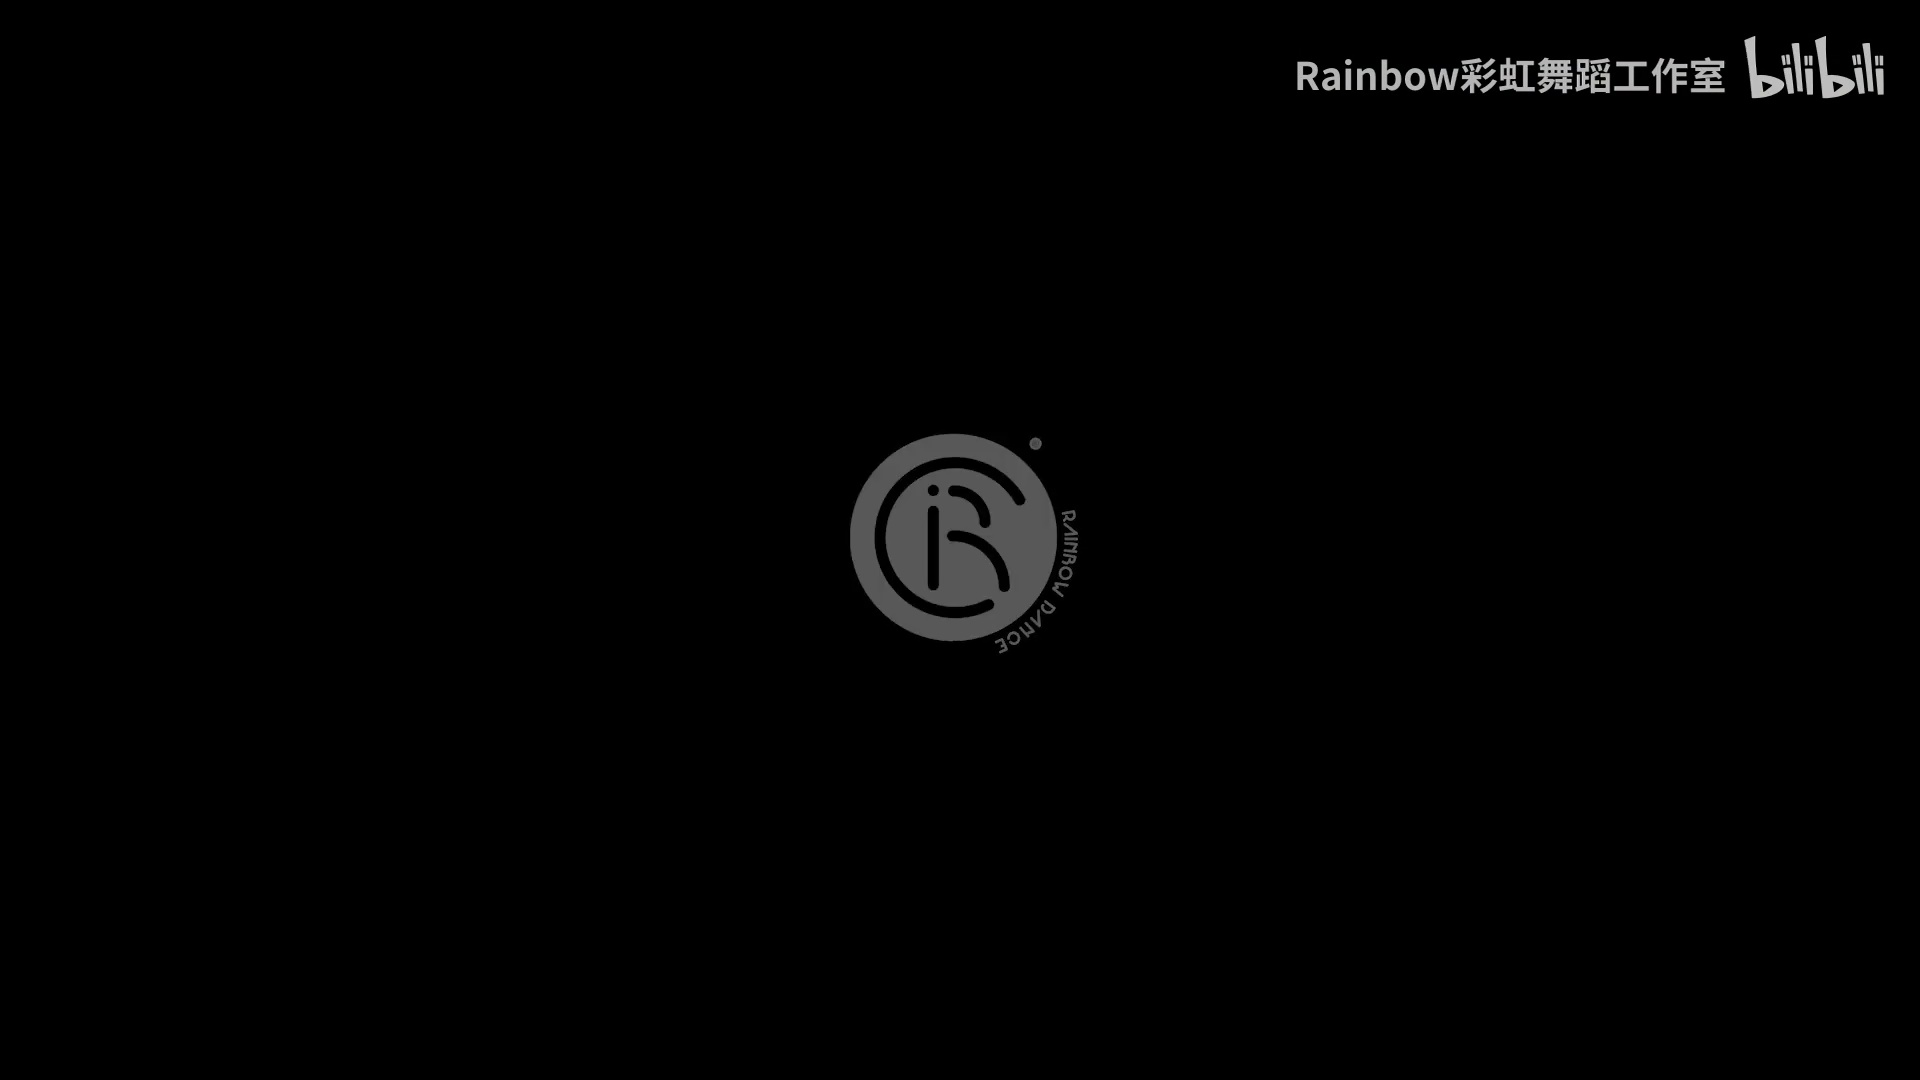

In [8]:
video_path = "./cache/dancer_demo.mp4"                                  # you should give me a mp4 file path
config_path = "../outputs/memotr_dancetrack/train/config.yaml"          # the config path of model
model_path = "../outputs/memotr_dancetrack/memotr_dancetrack.pth"       # the model checkpoint path

play_video(video_path)                                                  # play the video

## Run Demo

In [9]:
output_path = demo_processing(
    model_path=model_path,
    config_path=config_path,
    video_path=video_path,
)

Model loaded.
(1920, 1080)
Processing frame 0 (100000.00 fps)


/home/gaoruopeng/anaconda3/envs/MeMOTR/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541990/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Processing frame 20 (11.08 fps)
Processing frame 40 (12.78 fps)
Processing frame 60 (13.50 fps)
Processing frame 80 (13.90 fps)
Processing frame 100 (14.14 fps)
Processing frame 120 (14.24 fps)
Processing frame 140 (14.37 fps)
Processing frame 160 (14.48 fps)
Processing frame 180 (14.56 fps)
Processing frame 200 (14.62 fps)
Processing frame 220 (14.68 fps)
Processing frame 240 (14.72 fps)
Processing frame 260 (14.76 fps)
Processing frame 280 (14.78 fps)
Processing frame 300 (14.81 fps)
Processing frame 320 (14.84 fps)
Processing frame 340 (14.86 fps)
Processing frame 360 (14.88 fps)
Processing frame 380 (14.89 fps)
Processing frame 400 (14.91 fps)
Processing frame 420 (14.93 fps)
Processing frame 440 (14.94 fps)
Processing frame 460 (14.95 fps)
Processing frame 480 (14.96 fps)
Processing frame 500 (14.97 fps)
Processing frame 520 (14.98 fps)
Processing frame 540 (14.99 fps)
Processing frame 560 (15.00 fps)
Processing frame 580 (15.00 fps)
Processing frame 600 (15.01 fps)



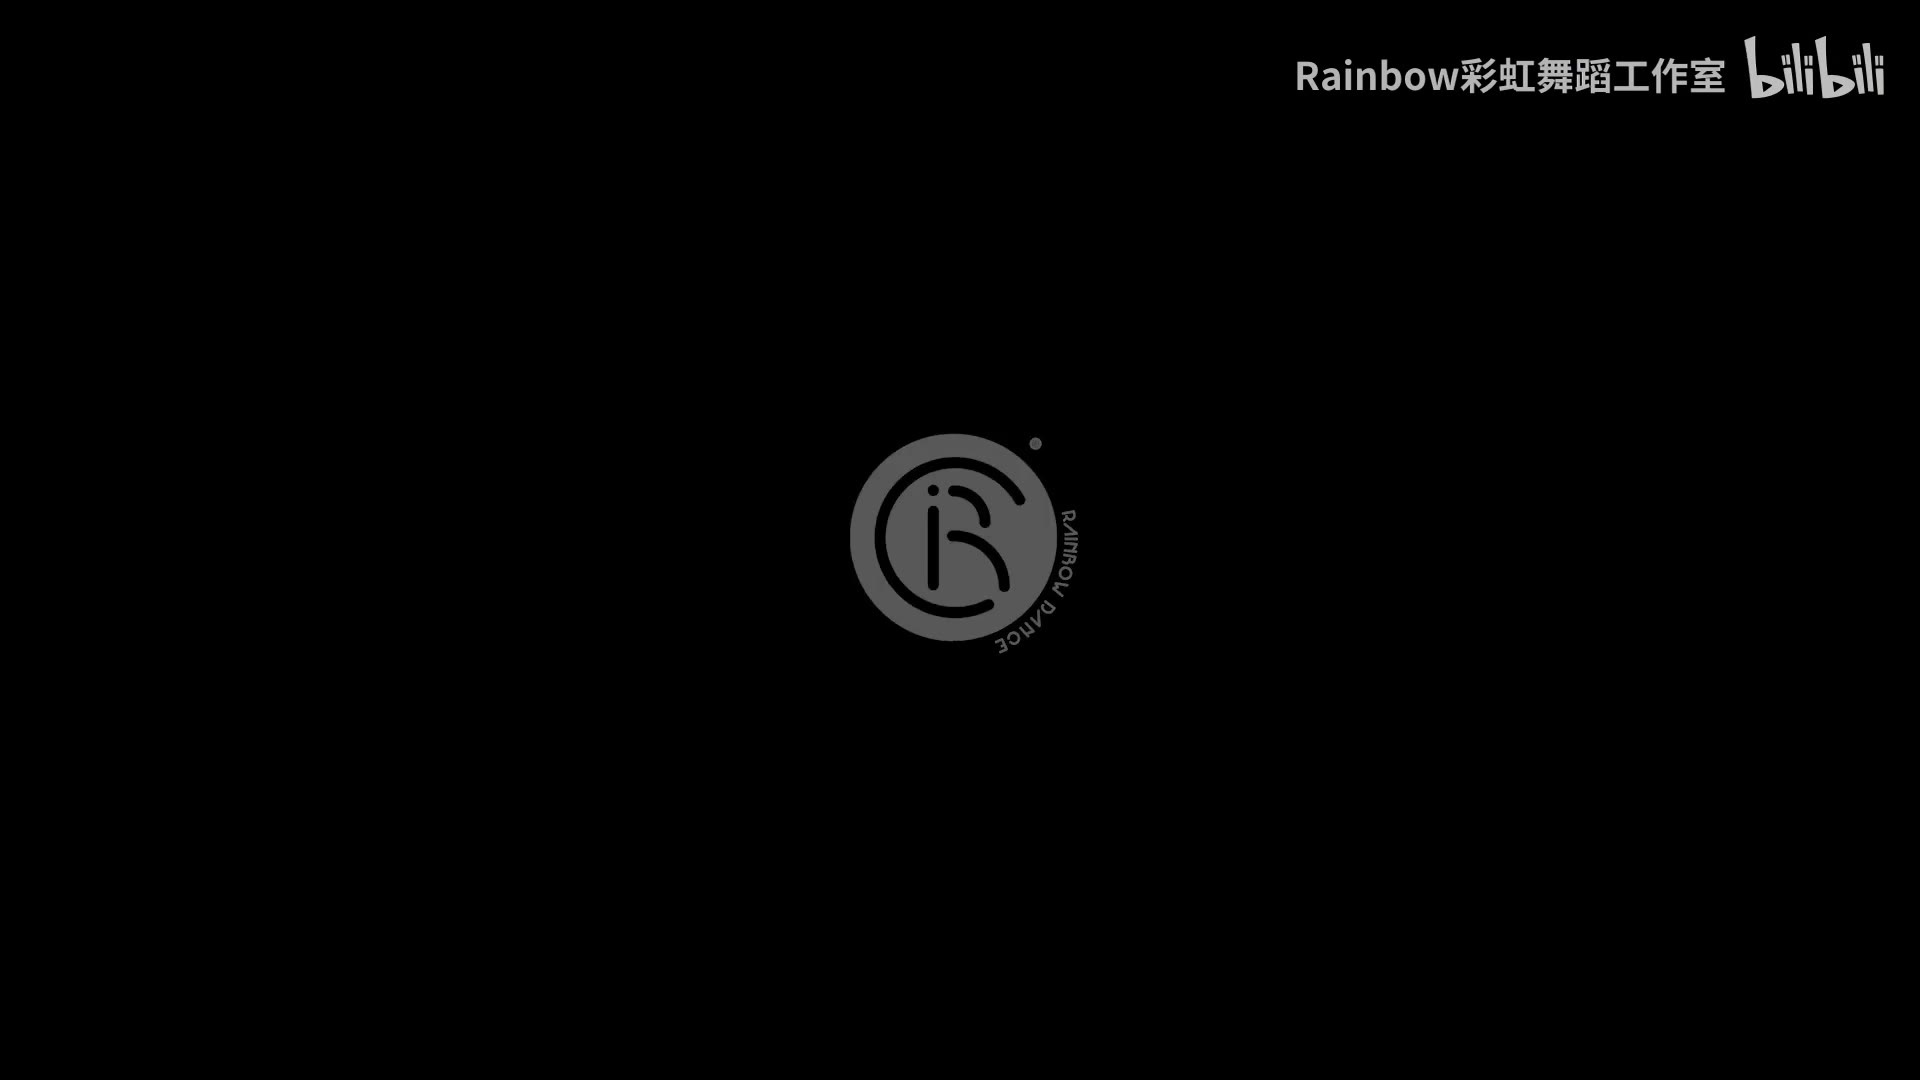

In [10]:
play_video(output_path)